In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

Based on: https://www.datacamp.com/tutorial/autoencoder-classifier-python

In [2]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
#merge
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [10]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels    

In [16]:
train_data = extract_data('fashion-mnist/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('fashion-mnist/t10k-images-idx3-ubyte.gz', 10000)
train_labels = extract_labels('fashion-mnist/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('fashion-mnist/t10k-labels-idx1-ubyte.gz',10000)

In [17]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [18]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: E)')

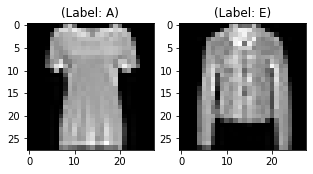

In [19]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")


In [21]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [22]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [23]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [24]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [25]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [32]:
batch_size = 64
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [33]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [34]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [35]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)        1849

In [36]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 128s 3ms/sample - loss: 0.0195 - val_loss: 0.0123
Epoch 2/10
48000/48000 [==============================] - 127s 3ms/sample - loss: 0.0090 - val_loss: 0.0070
Epoch 3/10
48000/48000 [==============================] - 127s 3ms/sample - loss: 0.0069 - val_loss: 0.0079
Epoch 4/10
48000/48000 [==============================] - 127s 3ms/sample - loss: 0.0056 - val_loss: 0.0056
Epoch 5/10
48000/48000 [==============================] - 127s 3ms/sample - loss: 0.0048 - val_loss: 0.0060
Epoch 6/10
48000/48000 [==============================] - 127s 3ms/sample - loss: 0.0042 - val_loss: 0.0039
Epoch 7/10
48000/48000 [==============================] - 128s 3ms/sample - loss: 0.0039 - val_loss: 0.0046
Epoch 8/10
48000/48000 [==============================] - 128s 3ms/sample - loss: 0.0035 - val_loss: 0.0055
Epoch 9/10
48000/48000 [==============================] - 127s 3ms/sample - loss: 0.00

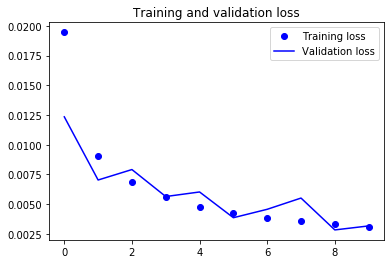

In [39]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [40]:
autoencoder.save_weights('autoencoder.h5')

In [41]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [42]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)


In [43]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape


((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [44]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [45]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [46]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [47]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [48]:
autoencoder.get_weights()[0][1]

array([[[-0.19229926, -0.11713836, -0.07831924, -0.11272333,
          0.12486244,  0.27511567,  0.03322825, -0.08130998,
         -0.21380201,  0.11533865,  0.02925554,  0.02607284,
          0.00707643,  0.10109482, -0.05347396, -0.11211778,
         -0.03356571, -0.2159118 , -0.13271254, -0.1641964 ,
         -0.09636329,  0.03763959,  0.14650299,  0.0375581 ,
          0.1275186 , -0.14741723, -0.13479073,  0.05114586,
          0.03455367, -0.137971  ,  0.22502384,  0.03499371]],

       [[-0.08326072,  0.04626201, -0.11059398, -0.12240118,
          0.18388808,  0.07379725,  0.33909994,  0.15903483,
         -0.21183933,  0.11825512,  0.11989909, -0.07956334,
         -0.06833865, -0.02245925, -0.17784978,  0.11068556,
          0.08438363, -0.14426942, -0.06748723,  0.02709283,
         -0.21571116,  0.00941322,  0.08886646,  0.17941059,
          0.13686718, -0.08445193,  0.06167563,  0.2070227 ,
         -0.12228215,  0.16402267,  0.15962064, -0.25083956]],

       [[ 0.139052

In [49]:
full_model.get_weights()[0][1]

array([[[-0.19229926, -0.11713836, -0.07831924, -0.11272333,
          0.12486244,  0.27511567,  0.03322825, -0.08130998,
         -0.21380201,  0.11533865,  0.02925554,  0.02607284,
          0.00707643,  0.10109482, -0.05347396, -0.11211778,
         -0.03356571, -0.2159118 , -0.13271254, -0.1641964 ,
         -0.09636329,  0.03763959,  0.14650299,  0.0375581 ,
          0.1275186 , -0.14741723, -0.13479073,  0.05114586,
          0.03455367, -0.137971  ,  0.22502384,  0.03499371]],

       [[-0.08326072,  0.04626201, -0.11059398, -0.12240118,
          0.18388808,  0.07379725,  0.33909994,  0.15903483,
         -0.21183933,  0.11825512,  0.11989909, -0.07956334,
         -0.06833865, -0.02245925, -0.17784978,  0.11068556,
          0.08438363, -0.14426942, -0.06748723,  0.02709283,
         -0.21571116,  0.00941322,  0.08886646,  0.17941059,
          0.13686718, -0.08445193,  0.06167563,  0.2070227 ,
         -0.12228215,  0.16402267,  0.15962064, -0.25083956]],

       [[ 0.139052

In [50]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [52]:
full_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])


In [53]:
full_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_28 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 64)        1849

In [55]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label))


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 22s 466us/sample - loss: 0.2001 - accuracy: 0.9254 - val_loss: 0.3099 - val_accuracy: 0.9039
Epoch 2/10
48000/48000 [==============================] - 23s 484us/sample - loss: 0.1783 - accuracy: 0.9323 - val_loss: 0.3408 - val_accuracy: 0.8932
Epoch 3/10
48000/48000 [==============================] - 23s 484us/sample - loss: 0.1619 - accuracy: 0.9382 - val_loss: 0.3137 - val_accuracy: 0.9021
Epoch 4/10
48000/48000 [==============================] - 23s 483us/sample - loss: 0.1444 - accuracy: 0.9457 - val_loss: 0.3437 - val_accuracy: 0.8932
Epoch 5/10
48000/48000 [==============================] - 23s 483us/sample - loss: 0.1309 - accuracy: 0.9499 - val_loss: 0.3582 - val_accuracy: 0.8989
Epoch 6/10
48000/48000 [==============================] - 23s 483us/sample - loss: 0.1165 - accuracy: 0.9560 - val_loss: 0.3774 - val_accuracy: 0.8999
Epoch 7/10
48000/48000 [====================

In [56]:
full_model.save_weights('autoencoder_classification.h5')

In [57]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [60]:
full_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [61]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label))


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 81s 2ms/sample - loss: 0.2035 - accuracy: 0.9306 - val_loss: 0.4021 - val_accuracy: 0.8992
Epoch 2/10
48000/48000 [==============================] - 81s 2ms/sample - loss: 0.1361 - accuracy: 0.9496 - val_loss: 0.4941 - val_accuracy: 0.8785
Epoch 3/10
48000/48000 [==============================] - 81s 2ms/sample - loss: 0.1216 - accuracy: 0.9558 - val_loss: 0.3521 - val_accuracy: 0.9009
Epoch 4/10
48000/48000 [==============================] - 81s 2ms/sample - loss: 0.1026 - accuracy: 0.9629 - val_loss: 0.3734 - val_accuracy: 0.9072
Epoch 5/10
48000/48000 [==============================] - 81s 2ms/sample - loss: 0.0884 - accuracy: 0.9671 - val_loss: 0.3743 - val_accuracy: 0.9053
Epoch 6/10
48000/48000 [==============================] - 81s 2ms/sample - loss: 0.0795 - accuracy: 0.9712 - val_loss: 0.3604 - val_accuracy: 0.9107
Epoch 7/10
48000/48000 [==============================] 

In [62]:
full_model.save_weights('classification_complete.h5')

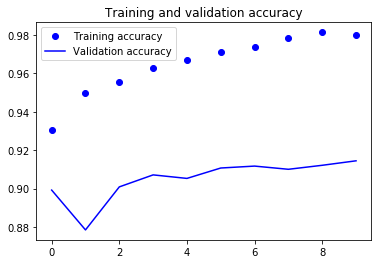

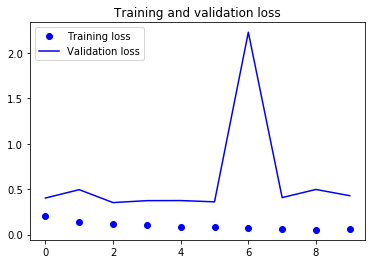

In [64]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [65]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

In [66]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.4478236992523074
Test accuracy: 0.9087


In [67]:
predicted_classes = full_model.predict(test_data)

In [68]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [69]:
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

Found %d correct labels 9080


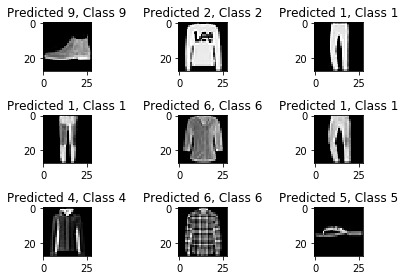

In [71]:
correct = np.where(predicted_classes==test_labels)[0]
print ("Found %d correct labels",len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Found %d incorrect labels 920


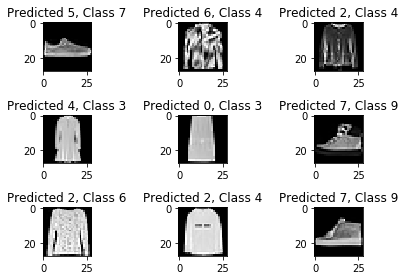

In [73]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print ("Found %d incorrect labels", len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

In [74]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.83      0.86      0.84      1000
     Class 1       0.99      0.98      0.99      1000
     Class 2       0.87      0.86      0.87      1000
     Class 3       0.93      0.87      0.90      1000
     Class 4       0.86      0.85      0.85      1000
     Class 5       0.99      0.97      0.98      1000
     Class 6       0.73      0.76      0.74      1000
     Class 7       0.96      0.97      0.96      1000
     Class 8       0.98      0.98      0.98      1000
     Class 9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

